In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_format = 'svg'
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from folium.plugins import FloatImage
from folium.plugins import MarkerCluster
from geopy.distance import geodesic

时间数据预处理

In [2]:

# 读取CSV文件
file_path = 'OriginalData.csv'
OriginalData = pd.read_csv(file_path)

# 查看数据
print(OriginalData.head())


              START_TIME  START_LAT               END_TIME     END_LNG  \
0  2021-07-18 23:37:10.0  22.722193  2021-07-19 00:30:48.0  114.293735   
1  2021-07-18 23:37:11.0  22.630734  2021-07-18 23:45:18.0  114.051401   
2  2021-07-18 23:37:11.0  22.630641  2021-07-18 23:45:18.0  114.051307   
3  2021-07-18 23:37:11.0  22.587205  2021-07-18 23:48:36.0  113.873857   
4  2021-07-18 23:37:11.0  22.583960  2021-07-18 23:52:19.0  113.956495   

    START_LNG    END_LAT  
0  114.287819  22.716855  
1  114.055318  22.635949  
2  114.055225  22.635856  
3  113.861478  22.580957  
4  113.954422  22.580334  


In [3]:
# 数据清理（如需要）
# 检查缺失值
print(OriginalData.isnull().sum())

# 示例处理：将时间列转换为datetime格式
OriginalData['START_TIME'] = pd.to_datetime(OriginalData['START_TIME'])
OriginalData['END_TIME'] = pd.to_datetime(OriginalData['END_TIME'])

# 计算行程时间（以分钟为单位）
OriginalData['TRIP_DURATION_MINUTES'] = (OriginalData['END_TIME'] - OriginalData['START_TIME']).dt.total_seconds() / 60

# 打印处理后的数据
print(OriginalData.head())

START_TIME    0
START_LAT     0
END_TIME      0
END_LNG       0
START_LNG     0
END_LAT       0
dtype: int64
           START_TIME  START_LAT            END_TIME     END_LNG   START_LNG  \
0 2021-07-18 23:37:10  22.722193 2021-07-19 00:30:48  114.293735  114.287819   
1 2021-07-18 23:37:11  22.630734 2021-07-18 23:45:18  114.051401  114.055318   
2 2021-07-18 23:37:11  22.630641 2021-07-18 23:45:18  114.051307  114.055225   
3 2021-07-18 23:37:11  22.587205 2021-07-18 23:48:36  113.873857  113.861478   
4 2021-07-18 23:37:11  22.583960 2021-07-18 23:52:19  113.956495  113.954422   

     END_LAT  TRIP_DURATION_MINUTES  
0  22.716855              53.633333  
1  22.635949               8.116667  
2  22.635856               8.116667  
3  22.580957              11.416667  
4  22.580334              15.133333  


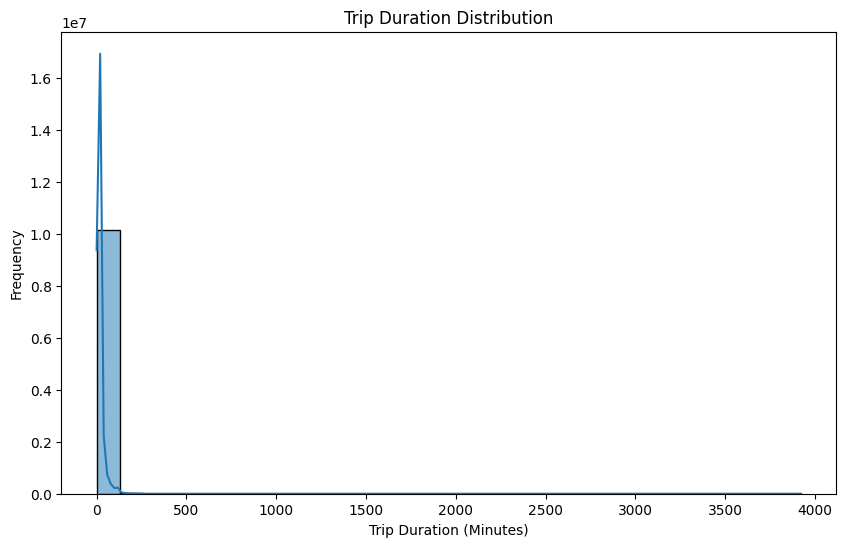

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(OriginalData['TRIP_DURATION_MINUTES'], bins=30, kde=True)  # kde=True 添加分布曲线
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Frequency')
plt.show()

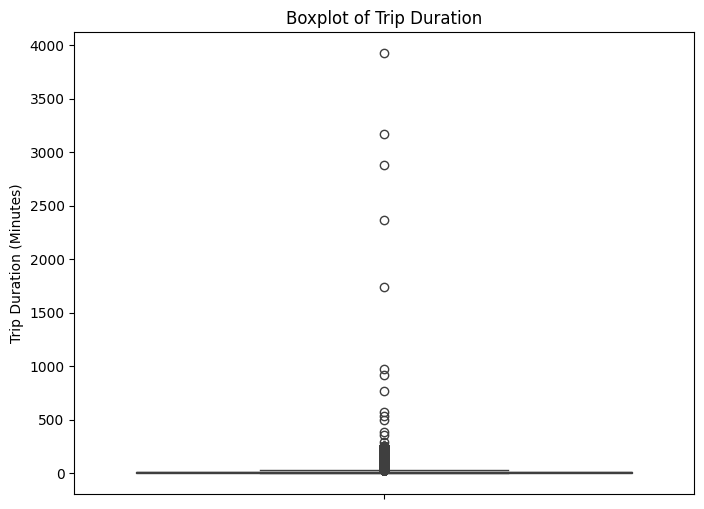

In [5]:
# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(y=OriginalData['TRIP_DURATION_MINUTES'])
plt.title('Boxplot of Trip Duration')
plt.ylabel('Trip Duration (Minutes)')
plt.show()

In [6]:
# 统计时间差为负值的数据数量
negative_durations_count = (OriginalData['TRIP_DURATION_MINUTES'] <= 0).sum()
small_durations_count = (OriginalData['TRIP_DURATION_MINUTES'] < 1).sum()
print(f"时间差小于等于0的数据数量: {negative_durations_count}")
print(f"时间差小于等于1的数据数量: {small_durations_count}")

# 删除时间差小于1的数据
data = OriginalData[OriginalData['TRIP_DURATION_MINUTES'] >= 1]

# 查看清理后的数据集信息
print(f"清理后的数据总数: {len(data)}")


时间差小于等于0的数据数量: 1411
时间差小于等于1的数据数量: 143006
清理后的数据总数: 10035942


In [7]:
# 对长尾分布的数据点进行对数变换
data['LOG_TRIP_DURATION'] = np.log(data['TRIP_DURATION_MINUTES'])

# 画对数变换前后的分布图
plt.figure(figsize=(12, 6))

C:\Users\MOMO\AppData\Local\Temp\ipykernel_23324\542806321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LOG_TRIP_DURATION'] = np.log(data['TRIP_DURATION_MINUTES'])


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

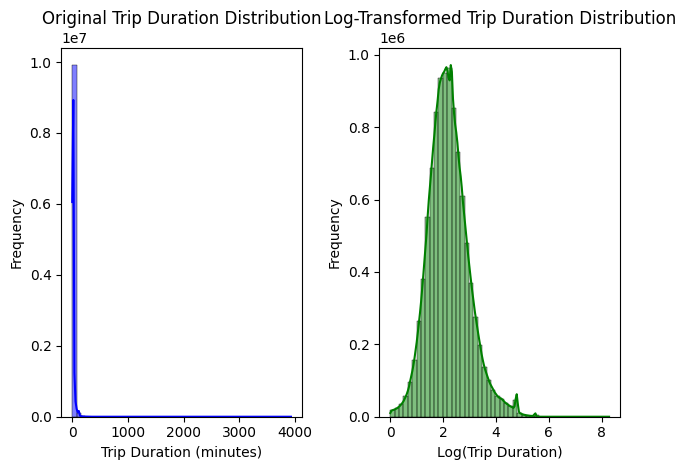

In [8]:
# 原始分布图
plt.subplot(1, 2, 1)
sns.histplot(data['TRIP_DURATION_MINUTES'], bins=50, kde=True, color='blue')
plt.title('Original Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')

# 对数变换后的分布图
plt.subplot(1, 2, 2)
sns.histplot(data['LOG_TRIP_DURATION'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Trip Duration Distribution')
plt.xlabel('Log(Trip Duration)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
mean = data['LOG_TRIP_DURATION'].mean()
std = data['LOG_TRIP_DURATION'].std()
upper_bound = mean + 3 * std

print(f"均值 (Mean): {mean}")
print(f"标准差 (Std): {std}")
print(f"上界 (Upper Bound): {upper_bound}")

# 定义3sigma范围
upper_bound = mean + 3 * std

均值 (Mean): 2.208285523764855
标准差 (Std): 0.7600161671339923
上界 (Upper Bound): 4.488334025166832


In [10]:
# 统计并删除超过3sigma的数据
outliers_count = (data['LOG_TRIP_DURATION'] > upper_bound).sum()
print(f"超过 3σ 范围的异常值数量: {outliers_count}")

# 删除超过3sigma的数据
data = data[data['LOG_TRIP_DURATION'] <= upper_bound]

# 查看清理后的数据集信息
print(f"清理后的数据总数: {len(data)}")

超过 3σ 范围的异常值数量: 98152
清理后的数据总数: 9937790


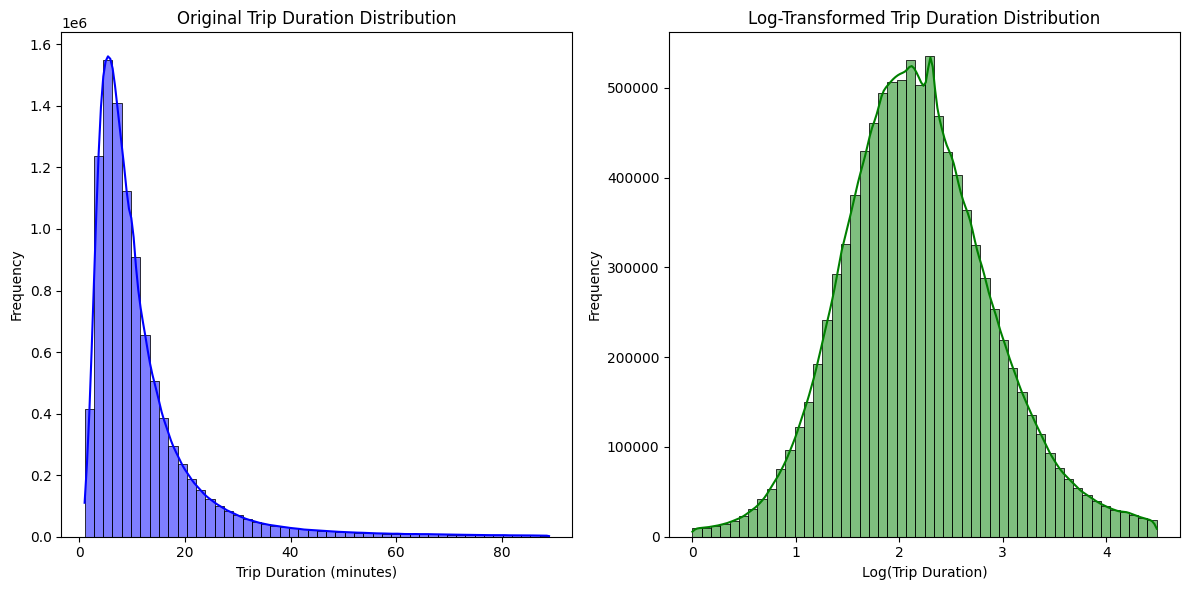

In [11]:
# 画分布图
plt.figure(figsize=(12, 6))

# 原始分布图
plt.subplot(1, 2, 1)
sns.histplot(data['TRIP_DURATION_MINUTES'], bins=50, kde=True, color='blue')
plt.title('Original Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')

# 对数变换后的分布图
plt.subplot(1, 2, 2)
sns.histplot(data['LOG_TRIP_DURATION'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Trip Duration Distribution')
plt.xlabel('Log(Trip Duration)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
# 计算行程时间（以分钟为单位）
data['TRIP_DURATION_MINUTES'] = (data['END_TIME'] - data['START_TIME']).dt.total_seconds() / 60

In [13]:
mean=data['TRIP_DURATION_MINUTES'].mean()
std=data['TRIP_DURATION_MINUTES'].std()
print(f"均值 (Mean): {mean}")
print(f"标准差 (Std): {std}")

均值 (Mean): 11.697454965674778
标准差 (Std): 10.684533523774087


In [14]:
# 打印处理后的数据
print(data.head())

# 查看清理后的数据集信息
print(f"清理后的数据总数: {len(data)}")

           START_TIME  START_LAT            END_TIME     END_LNG   START_LNG  \
0 2021-07-18 23:37:10  22.722193 2021-07-19 00:30:48  114.293735  114.287819   
1 2021-07-18 23:37:11  22.630734 2021-07-18 23:45:18  114.051401  114.055318   
2 2021-07-18 23:37:11  22.630641 2021-07-18 23:45:18  114.051307  114.055225   
3 2021-07-18 23:37:11  22.587205 2021-07-18 23:48:36  113.873857  113.861478   
4 2021-07-18 23:37:11  22.583960 2021-07-18 23:52:19  113.956495  113.954422   

     END_LAT  TRIP_DURATION_MINUTES  LOG_TRIP_DURATION  
0  22.716855              53.633333           3.982171  
1  22.635949               8.116667           2.093920  
2  22.635856               8.116667           2.093920  
3  22.580957              11.416667           2.435074  
4  22.580334              15.133333           2.716900  
清理后的数据总数: 9937790


In [15]:
# 删除指定的列
data_Timecleaned = data.drop(columns=['TRIP_DURATION_MINUTES', 'LOG_TRIP_DURATION'])

# 查看结果
print(data_Timecleaned.head())

# 查看清理后的数据集信息
print(f"清理后的数据总数: {len(data)}")


           START_TIME  START_LAT            END_TIME     END_LNG   START_LNG  \
0 2021-07-18 23:37:10  22.722193 2021-07-19 00:30:48  114.293735  114.287819   
1 2021-07-18 23:37:11  22.630734 2021-07-18 23:45:18  114.051401  114.055318   
2 2021-07-18 23:37:11  22.630641 2021-07-18 23:45:18  114.051307  114.055225   
3 2021-07-18 23:37:11  22.587205 2021-07-18 23:48:36  113.873857  113.861478   
4 2021-07-18 23:37:11  22.583960 2021-07-18 23:52:19  113.956495  113.954422   

     END_LAT  
0  22.716855  
1  22.635949  
2  22.635856  
3  22.580957  
4  22.580334  
清理后的数据总数: 9937790


In [ ]:
# 将 data_Timecleaned 写入 CSV 文件
output_file_path = 'data_TimeCleaned.csv'
data_Timecleaned.to_csv(output_file_path, index=False)

print(f"数据已成功保存到 {output_file_path}")


数据已成功保存到 data_Timecleaned


地理数据预处理

In [17]:
import rasterio
from rasterio.transform import rowcol
from shapely.geometry import Point


筛选起始点/结束点在深圳市区范围外的数据

In [18]:
# 读取深圳市边界 GeoJSON 文件
geojson_path = r"E:\数据挖掘与商务分析\Final\深圳市边界_440300_GeoJSON_(poi86.com)\440300.geojson"
shenzhen_boundary = gpd.read_file(geojson_path)

# 确保 GeoJSON 文件的几何数据有效
if shenzhen_boundary.geometry.is_empty.any():
    raise ValueError("GeoJSON 文件中的几何数据为空，请检查文件格式或内容。")

# 如果边界是多个区域，合并为单一多边形
shenzhen_polygon = shenzhen_boundary.unary_union


C:\Users\MOMO\AppData\Local\Temp\ipykernel_23324\3524321878.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shenzhen_polygon = shenzhen_boundary.unary_union


<Figure size 1000x1000 with 0 Axes>

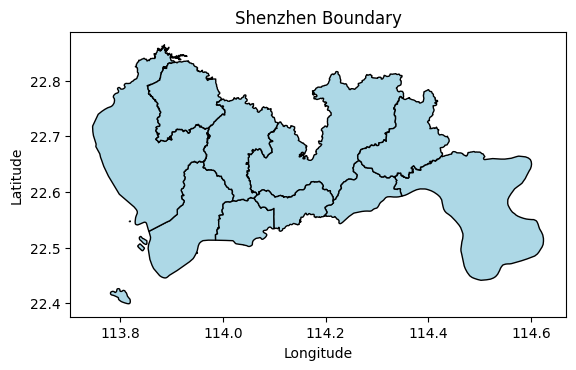

In [19]:
# 可视化深圳市边界
plt.figure(figsize=(10, 10))  # 设置图像大小
shenzhen_boundary.plot(edgecolor='black', facecolor='lightblue')  # 绘制边界
plt.title("Shenzhen Boundary")  # 设置标题
plt.xlabel("Longitude")  # 设置x轴标签
plt.ylabel("Latitude")  # 设置y轴标签
plt.show()  # 显示图像

In [ ]:
#从data_Timecleaned读取数据
data_Timecleaned=pd.read_csv('data_TimeCleaned.csv')

In [20]:
bike_data = pd.DataFrame(data_Timecleaned)

# 创建几何点
bike_data['start_point'] = bike_data.apply(
    lambda row: Point(row['START_LNG'], row['START_LAT']), axis=1
)
bike_data['end_point'] = bike_data.apply(
    lambda row: Point(row['END_LNG'], row['END_LAT']), axis=1
)

# 转换为 GeoDataFrame
bike_gdf = gpd.GeoDataFrame(bike_data, geometry='start_point')


In [21]:
# 判断起点和终点是否在深圳边界内
bike_gdf['start_within_boundary'] = bike_gdf['start_point'].apply(shenzhen_polygon.contains)
bike_gdf['end_within_boundary'] = bike_gdf['end_point'].apply(shenzhen_polygon.contains)

# 标记起点或终点超出范围的数据
bike_gdf['out_of_boundary'] = ~bike_gdf['start_within_boundary'] | ~bike_gdf['end_within_boundary']

# 统计不在范围内的点的数量
out_of_boundary_count = bike_gdf['out_of_boundary'].sum()
print(f"共有 {out_of_boundary_count} 个点超出深圳市边界范围。")

# 筛选起点和终点均在边界内的数据
filtered_bike_gdf = bike_gdf[
    bike_gdf['start_within_boundary'] & bike_gdf['end_within_boundary']
]


共有 235970 个点超出深圳市边界范围。


In [ ]:
# 删除指定的列
filtered_bike_gdf = filtered_bike_gdf.drop(columns=['start_within_boundary', 'end_within_boundary', 'out_of_boundary'])

# 将数据保存到 CSV 文件
output_file_path = 'data_GeoCleaned.csv'
filtered_bike_gdf.to_csv(output_file_path, index=False)

print(f"已删除指定列并保存数据到 {output_file_path}")

已删除指定列并保存数据到 data_Geocleaned.csv


查看超出范围的数据，与数据预处理无关

In [23]:
# 筛选出超出范围的数据
out_of_boundary_data = bike_gdf[bike_gdf['out_of_boundary'] == True]


In [ ]:
import folium

# 创建一个基本地图，设置初始位置为深圳的中心（经纬度）
map_shenzhen = folium.Map(location=[22.548, 114.085], zoom_start=12)

# shenzhen_polygon 是 GeoDataFrame，通过 `folium.GeoJson` 加载并绘制
folium.GeoJson(shenzhen_polygon).add_to(map_shenzhen)

# 添加不在边界内的点
for _, row in out_of_boundary_data.iterrows():
    # 红色圆点表示起点，绿色圆点表示终点
    folium.CircleMarker(
        location=[row['START_LAT'], row['START_LNG']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"Start: {row['START_LAT']}, {row['START_LNG']}"
    ).add_to(map_shenzhen)

    folium.CircleMarker(
        location=[row['END_LAT'], row['END_LNG']],
        radius=5,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        popup=f"End: {row['END_LAT']}, {row['END_LNG']}"
    ).add_to(map_shenzhen)

# 保存为 HTML 文件，并在浏览器中查看
map_shenzhen.save("shenzhen_bike_points.html")


筛选距离异常数据

In [ ]:

# 读取CSV文件
file_path = 'data_GeoCleaned.csv'
data = pd.read_csv(file_path)

# 查看数据
print(data.head())

# 查看数据条数
print(len(data))


            START_TIME  START_LAT             END_TIME     END_LNG  \
0  2021-07-18 23:37:10  22.722193  2021-07-19 00:30:48  114.293735   
1  2021-07-18 23:37:11  22.630734  2021-07-18 23:45:18  114.051401   
2  2021-07-18 23:37:11  22.630641  2021-07-18 23:45:18  114.051307   
3  2021-07-18 23:37:11  22.587205  2021-07-18 23:48:36  113.873857   
4  2021-07-18 23:37:11  22.583960  2021-07-18 23:52:19  113.956495   

    START_LNG    END_LAT                       start_point  \
0  114.287819  22.716855      POINT (114.287819 22.722193)   
1  114.055318  22.635949  POINT (114.05531813 22.63073398)   
2  114.055225  22.635856  POINT (114.05522493 22.63064078)   
3  113.861478  22.580957    POINT (113.8614776 22.5872051)   
4  113.954422  22.580334       POINT (113.954422 22.58396)   

                              end_point  
0          POINT (114.293735 22.716855)  
1      POINT (114.05140056 22.63594924)  
2      POINT (114.05130736 22.63585604)  
3  POINT (113.8738566035 22.5809568497

In [9]:
# 计算每条记录的出发点和结束点的距离（单位为米）
distances = []

for index, row in data.iterrows():
    start_point = (row['START_LAT'], row['START_LNG'])
    end_point = (row['END_LAT'], row['END_LNG'])
    distance = geodesic(start_point, end_point).meters  # 计算距离，单位为米
    distances.append(distance)

# 将距离添加到 DataFrame 中
data['distance_m'] = distances



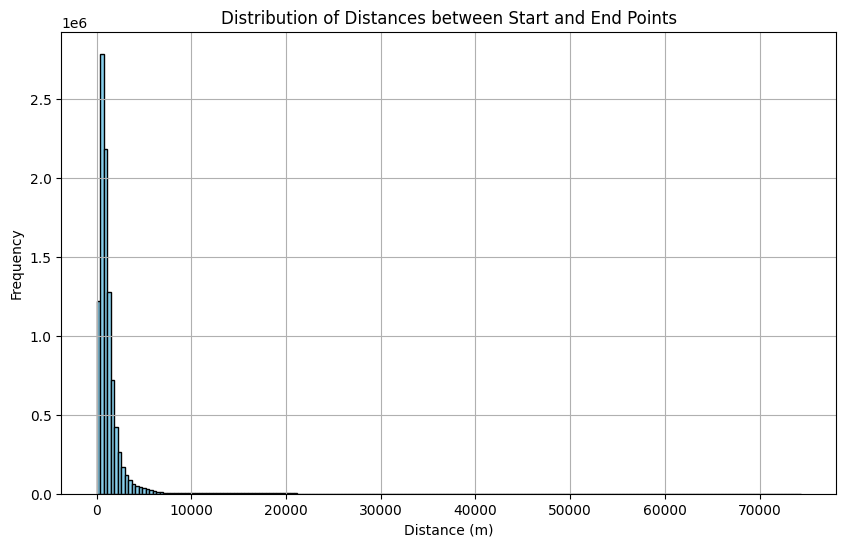

In [18]:
# 绘制距离的分布图
plt.figure(figsize=(10, 6))
plt.hist(data['distance_m'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Distances between Start and End Points')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
# 写入 CSV 文件
output_file_path = 'length.csv'
data.to_csv(output_file_path, index=False)

print(f"数据已成功保存到 {output_file_path}")


数据已成功保存到 length.csv


In [22]:
#删除小于1米的记录
data = data[data['distance_m'] > 1]

# 对长尾分布的数据点进行对数变换
data['LOG_distance_m'] = np.log(data['distance_m'])

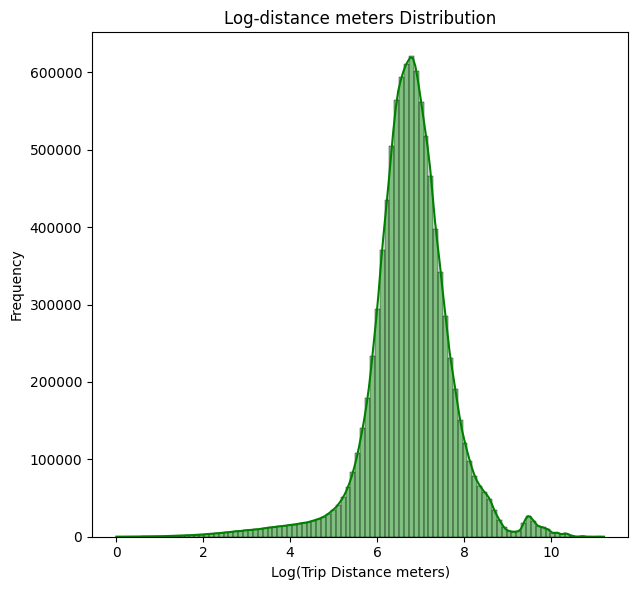

In [24]:
# 画分布图
plt.figure(figsize=(12, 6))

# 对数变换后的分布图
plt.subplot(1, 2, 2)
sns.histplot(data['LOG_distance_m'], bins=100, kde=True, color='green')
plt.title('Log-distance meters Distribution')
plt.xlabel('Log(Trip Distance meters)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
mean=data['LOG_distance_m'].mean()
std=data['LOG_distance_m'].std()

# 定义3sigma范围
upper_bound = mean + 3 * std

print(f"均值 (Mean): {mean}")
print(f"标准差 (Std): {std}")
print(f"3σ 上限 (Upper Bound): {upper_bound}")

均值 (Mean): 6.743213835740721
标准差 (Std): 0.9623623527522485
3σ 上限 (Upper Bound): 9.630300893997466


In [ ]:
# 统计并删除超过3sigma的数据
outliers_count = (data['LOG_distance_m'] > upper_bound).sum()
print(f"右侧超过 3σ 范围的异常值数量: {outliers_count}")

# 删除超过3sigma的数据
data = data[data['LOG_distance_m'] <= upper_bound]

# 查看清理后的数据集信息
print(f"清理后的数据总数: {len(data)}")

超过 3σ 范围的异常值数量: 57032
清理后的数据总数: 9638801


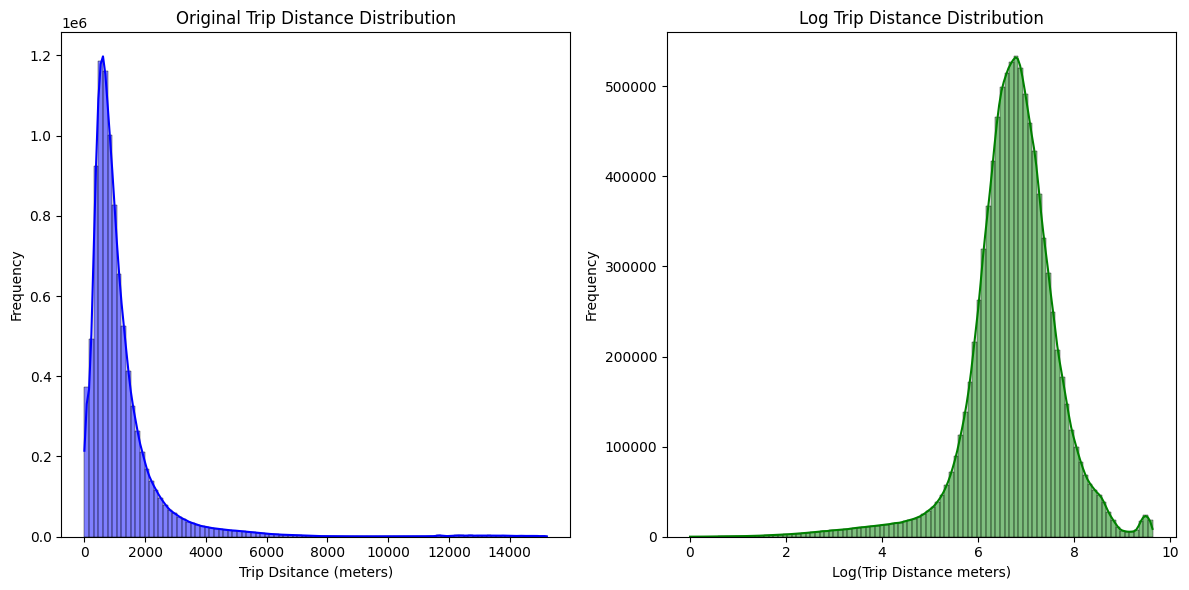

In [30]:
# 画分布图
plt.figure(figsize=(12, 6))

# 原始分布图
plt.subplot(1, 2, 1)
sns.histplot(data['distance_m'], bins=100, kde=True, color='blue')
plt.title('Original Trip Distance Distribution')
plt.xlabel('Trip Dsitance (meters)')
plt.ylabel('Frequency')

# 对数变换后的分布图
plt.subplot(1, 2, 2)
sns.histplot(data['LOG_distance_m'], bins=100, kde=True, color='green')
plt.title('Log Trip Distance Distribution')
plt.xlabel('Log(Trip Distance meters)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

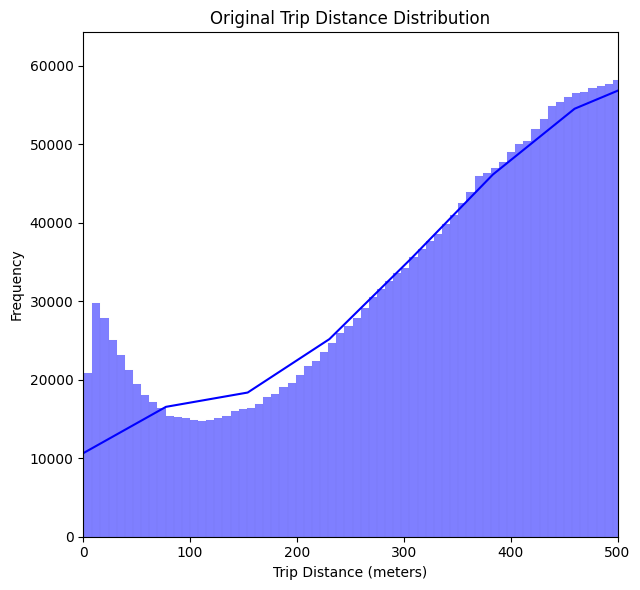

In [32]:
# 画分布图
plt.figure(figsize=(12, 6))

# 原始分布图
plt.subplot(1, 2, 1)
sns.histplot(data['distance_m'], bins=2000, kde=True, color='blue')  # 增加细分度，200个bin
plt.title('Original Trip Distance Distribution')
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Frequency')

# 设置x轴范围，只显示靠近0的部分，例如 0 到 500 米
plt.xlim(0, 500)

# 显示图表
plt.tight_layout()
plt.show()

In [37]:
mean=data['distance_m'].mean()
std=data['distance_m'].std()

#打印均值和标准差
print(f"均值 (Mean): {mean}")
print(f"标准差 (Std): {std}")

#打印数据点个数
print(f"数据点个数: {len(data)}")

#查看列名
print(data.columns)


均值 (Mean): 1225.2360042016069
标准差 (Std): 1427.6989083869953
数据点个数: 9638801
Index(['START_TIME', 'START_LAT', 'END_TIME', 'END_LNG', 'START_LNG',
       'END_LAT', 'start_point', 'end_point', 'distance_m', 'LOG_distance_m'],
      dtype='object')


In [ ]:
# 删除 'LOG_distance_m' 列
data = data.drop(columns=['LOG_distance_m'])

output_file_path='data_LengthCleaned.csv'

#保存至csv文件
data.to_csv(output_file_path, index=False)

print(f"已删除指定列并保存数据到 {output_file_path}")

In [58]:
#读取data_lengthcleaned.csv文件
data = pd.read_csv('data_LengthCleaned.csv')

#查看列名
print(data.columns)

#查看数据集信息
print(data.info())


Index(['START_TIME', 'START_LAT', 'END_TIME', 'END_LNG', 'START_LNG',
       'END_LAT', 'start_point', 'end_point', 'distance_m'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9638801 entries, 0 to 9638800
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   START_TIME   object 
 1   START_LAT    float64
 2   END_TIME     object 
 3   END_LNG      float64
 4   START_LNG    float64
 5   END_LAT      float64
 6   start_point  object 
 7   end_point    object 
 8   distance_m   float64
dtypes: float64(5), object(4)
memory usage: 661.8+ MB
None


In [59]:
#计算行程时间
# 将时间列转换为datetime格式
data['START_TIME'] = pd.to_datetime(data['START_TIME'])
data['END_TIME'] = pd.to_datetime(data['END_TIME'])

# 计算行程时间（以分钟为单位）
data['duration_min'] = (data['END_TIME'] - data['START_TIME']).dt.total_seconds() / 60

#查看数据集信息
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9638801 entries, 0 to 9638800
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   START_TIME    datetime64[ns]
 1   START_LAT     float64       
 2   END_TIME      datetime64[ns]
 3   END_LNG       float64       
 4   START_LNG     float64       
 5   END_LAT       float64       
 6   start_point   object        
 7   end_point     object        
 8   distance_m    float64       
 9   duration_min  float64       
dtypes: datetime64[ns](2), float64(6), object(2)
memory usage: 735.4+ MB
None


In [60]:
#写入csv文件
data.to_csv('data_Time_Space.csv', index=False)

筛选速度异常

In [61]:
# 计算速度 (米/秒)
data['speed_m_s'] = data['distance_m'] / (data['duration_min'] * 60)

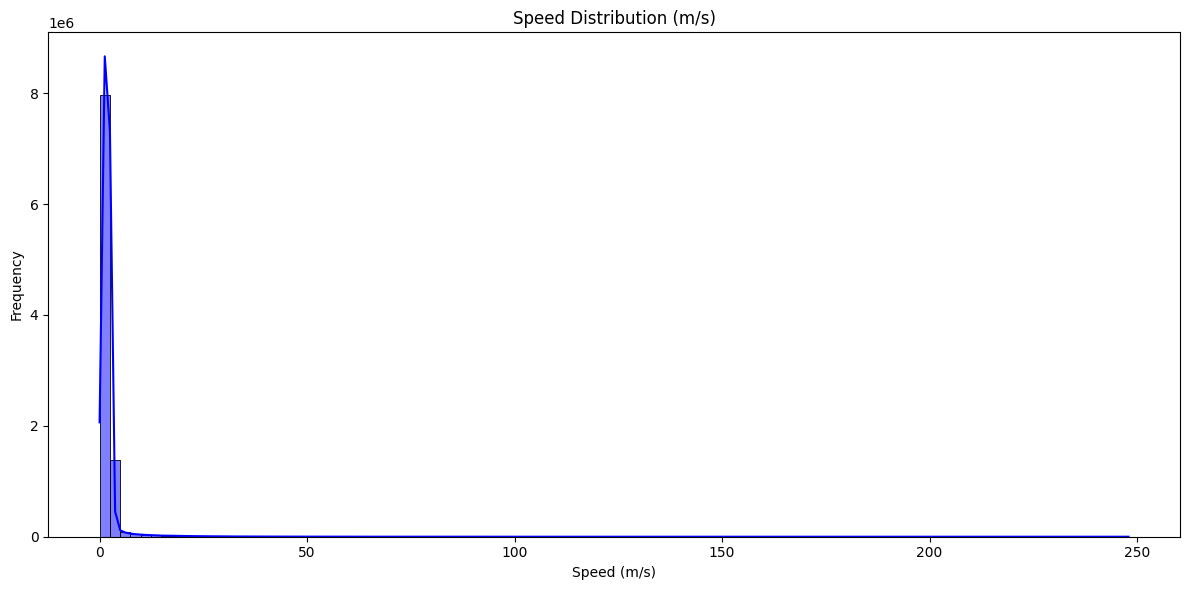

In [45]:
# 绘制速度的分布图
plt.figure(figsize=(12, 6))
sns.histplot(data['speed_m_s'], bins=100, kde=True, color='blue')

# 设置图表标题和标签
plt.title('Speed Distribution (m/s)')
plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')

# 显示图表
plt.tight_layout()
plt.show()

In [62]:
# 对速度进行对数变换，避免零或负数值，使用 np.log 进行自然对数转换
data['log_speed_m_s'] = np.log(data['speed_m_s'] + 1)  # 加1避免log(0)的错误


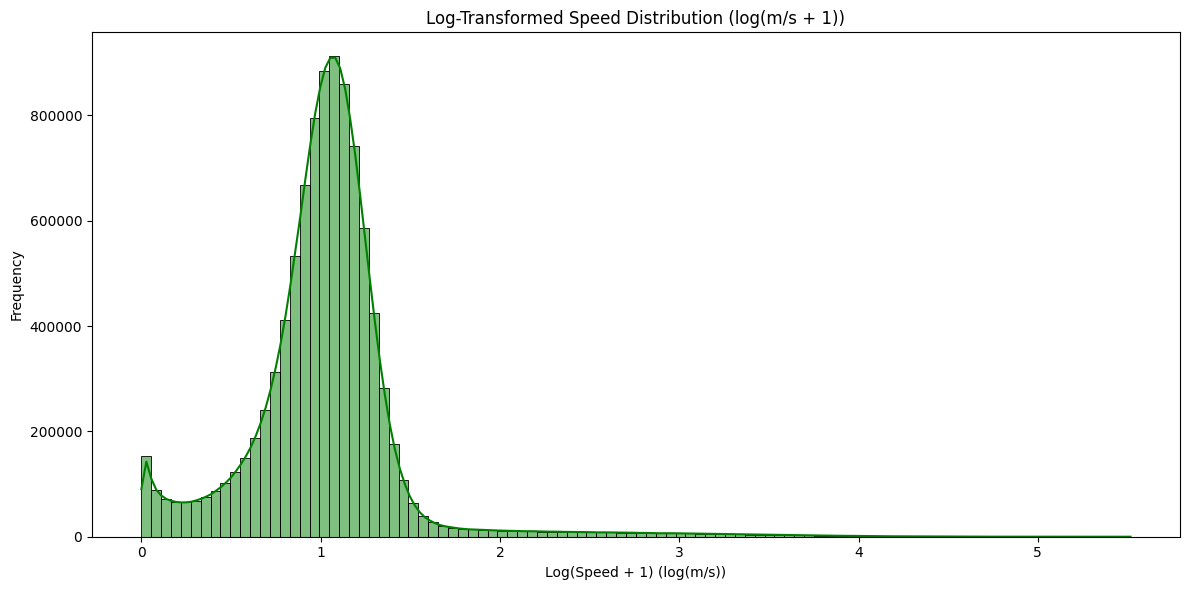

In [47]:
# 绘制对数化后的速度分布图
plt.figure(figsize=(12, 6))
sns.histplot(data['log_speed_m_s'], bins=100, kde=True, color='green')

# 设置图表标题和标签
plt.title('Log-Transformed Speed Distribution (log(m/s + 1))')
plt.xlabel('Log(Speed + 1) (log(m/s))')
plt.ylabel('Frequency')

# 显示图表
plt.tight_layout()
plt.show()

In [63]:
# 计算对数变换后的速度的均值和标准差
mean_log_speed = data['log_speed_m_s'].mean()
std_log_speed = data['log_speed_m_s'].std()

# 计算3σ上限
upper_limit_log = mean_log_speed + 3 * std_log_speed

#打印
print(f"均值 (Mean): {mean_log_speed}")
print(f"标准差 (Std): {std_log_speed}")
print(f"3σ上限 (Upper Limit): {upper_limit_log}")

# 记录删除之前的数据个数
before_deletion = len(data)

print(f"删除之前的数据个数: {before_deletion}")

#查看data信息
print(data.info())

均值 (Mean): 1.021762678609732
标准差 (Std): 0.4284537449597468
3σ上限 (Upper Limit): 2.3071239134889723
删除之前的数据个数: 9638801
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9638801 entries, 0 to 9638800
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   START_TIME     datetime64[ns]
 1   START_LAT      float64       
 2   END_TIME       datetime64[ns]
 3   END_LNG        float64       
 4   START_LNG      float64       
 5   END_LAT        float64       
 6   start_point    object        
 7   end_point      object        
 8   distance_m     float64       
 9   duration_min   float64       
 10  speed_m_s      float64       
 11  log_speed_m_s  float64       
dtypes: datetime64[ns](2), float64(8), object(2)
memory usage: 882.5+ MB
None


In [64]:
# 删除超出3σ上限的对数变换后速度的数据
data_SpeedCleaned = data[data['log_speed_m_s'] <= upper_limit_log]

# 记录删除之后的数据个数
after_deletion = len(data_SpeedCleaned)

# 统计被删除的数据个数
deleted_count = before_deletion - after_deletion

#打印被删除的数据个数
print(f"删除后的数据个数: {after_deletion}")
print(f"删除的数据个数: {deleted_count}")

删除后的数据个数: 9462675
删除的数据个数: 176126


In [65]:
#将data_SpeedCleaned删除log_speed_m_s列
data = data_SpeedCleaned.drop(columns=['log_speed_m_s'])

#查看data信息
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9462675 entries, 0 to 9638800
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   START_TIME    datetime64[ns]
 1   START_LAT     float64       
 2   END_TIME      datetime64[ns]
 3   END_LNG       float64       
 4   START_LNG     float64       
 5   END_LAT       float64       
 6   start_point   object        
 7   end_point     object        
 8   distance_m    float64       
 9   duration_min  float64       
 10  speed_m_s     float64       
dtypes: datetime64[ns](2), float64(7), object(2)
memory usage: 866.3+ MB
None


In [66]:
#将data写入csv文件
data.to_csv('data_SpeedCleaned.csv', index=False)

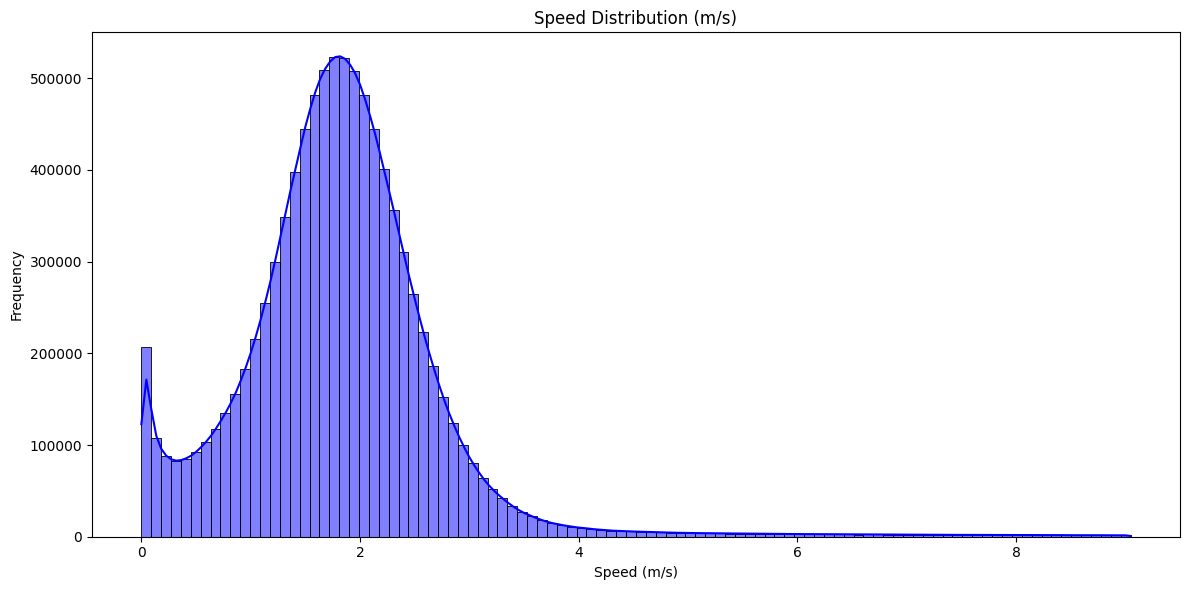

In [67]:
#读取data_SpeedCleaned.csv文件
data = pd.read_csv('data_SpeedCleaned.csv')

#画出速度speed_m_s分布图
# 绘制速度的分布图
plt.figure(figsize=(12, 6))
sns.histplot(data['speed_m_s'], bins=100, kde=True, color='blue')

# 设置图表标题和标签
plt.title('Speed Distribution (m/s)')
plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')

# 显示图表
plt.tight_layout()
plt.show()

In [68]:
# 计算速度的均值和标准差
mean_speed = data['speed_m_s'].mean()
std_speed = data['speed_m_s'].std()

#打印
print(f"均值 (Mean): {mean_speed}")
print(f"标准差 (Std): {std_speed}")


均值 (Mean): 1.8193239987208236
标准差 (Std): 0.9315266190115339
